In [63]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
def waist_from_measurements(data, measurements):
    known_xs = measurements["Displacement (m)"].values
    known_ps = measurements["Power (W)"].values

    
    well_defined_data = servo.get_rows_with_known_displacement(data, known_ps)
    speed = servo.characterise_speed(well_defined_data, known_xs)
    print("Speed: ", speed)
    data = servo.convert_time_to_displacement(data, well_defined_data, speed)
    waist, _, __ = plot.plot_beam_profile(data, "")
    return waist
"""

'\ndef waist_from_measurements(data, measurements):\n    known_xs = measurements["Displacement (m)"].values\n    known_ps = measurements["Power (W)"].values\n\n    \n    well_defined_data = servo.get_rows_with_known_displacement(data, known_ps)\n    speed = servo.characterise_speed(well_defined_data, known_xs)\n    print("Speed: ", speed)\n    data = servo.convert_time_to_displacement(data, well_defined_data, speed)\n    waist, _, __ = plot.plot_beam_profile(data, "")\n    return waist\n'

In [64]:
speed_3_data = pd.DataFrame({
    "times": [1.85449, 1.92676, 1.88867, 1.90918, 1.88672, 1.93359, 1.92383, 1.84668, 1.87012, 1.96777, 1.92969, 1.94433, 1.85351, 1.87109, 1.93652, 2.00976, 1.74121, 1.94922, 1.92285, 1.92383, 1.95215, 1.88086, 1.91113, 1.88086, 1.93164, 1.87695, 1.80859, 1.93164, 1.90625, 2.00683],    
})
speed_4_data = pd.DataFrame({
    "times": [1.4082, 1.36133, 1.35059, 1.37695, 1.41113, 1.3584, 1.37305, 1.39062, 1.39062, 1.36426, 1.38574, 1.41797, 1.3584, 1.44141, 1.30762, 1.38281, 1.31738, 1.47558, 1.36035, 1.39844, 1.43652, 1.34668, 1.36816, 1.37695, 1.39258, 1.44043, 1.37402, 1.38965, 1.41992, 1.27148, 1.46484, 1.37207, 1.32519, 1.44043, 1.39941],
})

files = np.array([ [f"Data/{p}/{n}.csv" for n in range(1,4)] for p in [ f"p{N}" for N in range(0,6)] ]).flatten()

velocity_3, velocity_4 = list(map(lambda data: (data
              .pipe(analyse.get_std_of_times)
              .pipe(analyse.get_velocity)
              .pipe(analyse.get_velocity_std)
              .pipe(analyse.get_velocity_and_error)
             ), [speed_3_data, speed_4_data]))

def waist_from_pre_char_speed(timestamped_data, velocity):

    displacement_data = (timestamped_data
                         .pipe(servo.reindex_timestamps_with_times)
                         .pipe(servo.calculate_displacement, velocity)
                         .pipe(servo.get_distances)
                         .pipe(servo.calculate_distances_error, velocity)
                        )

    
    waist, _, __ = plot.plot_beam_profile(displacement_data, "")
    return waist

def collate_results(files, velocity):
    measurements = map(servo.get_data, files)
    diameters = list(map(lambda m: waist_from_pre_char_speed(m, velocity), measurements))

    return diameters
    



2.350333333333334


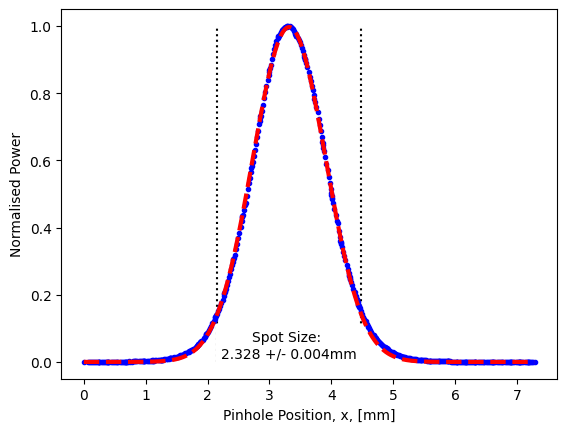

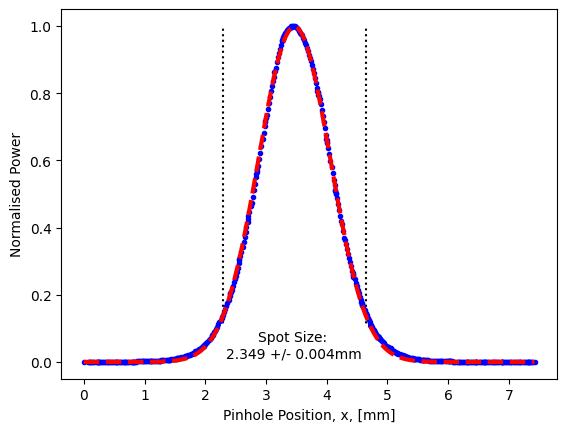

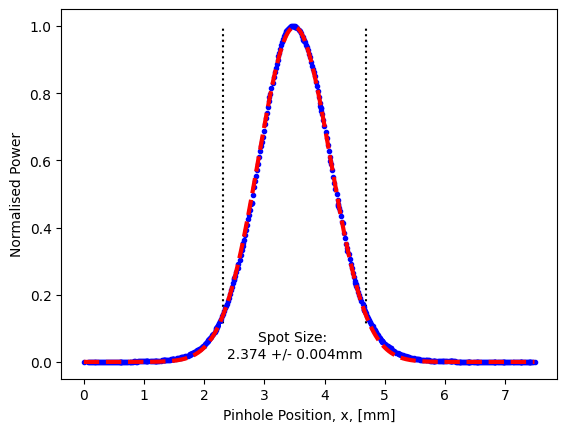

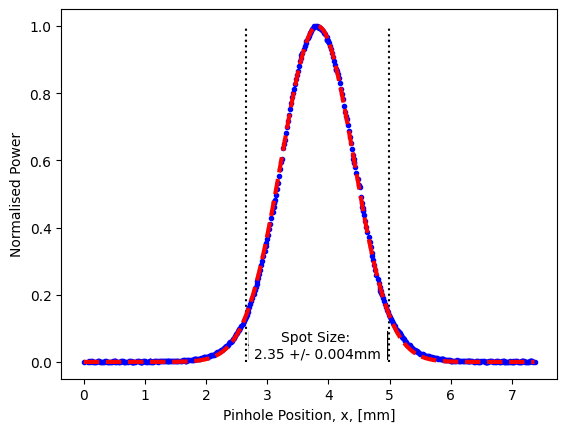

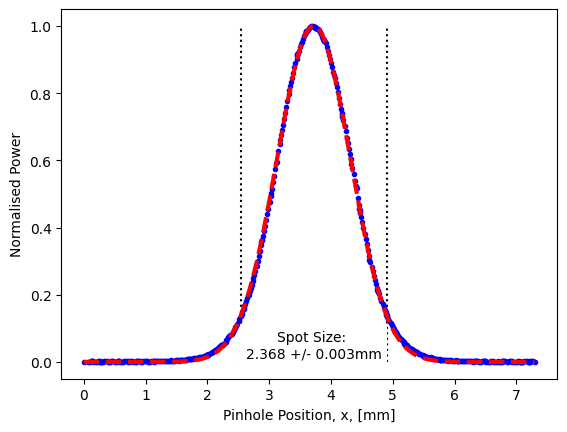

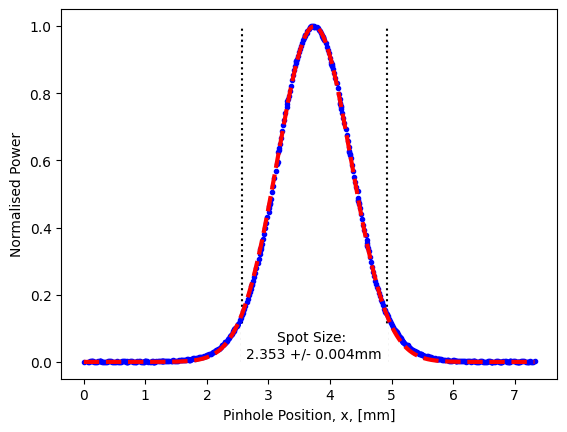

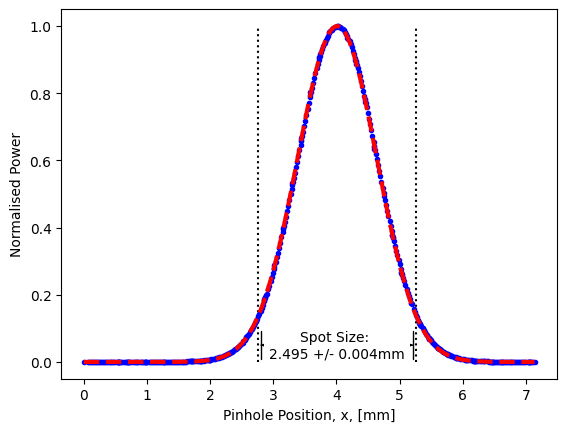

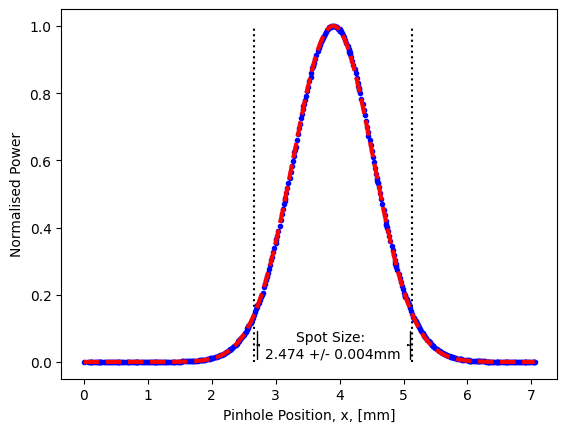

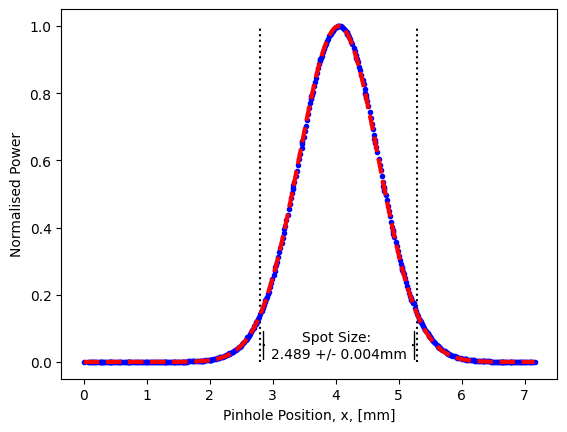

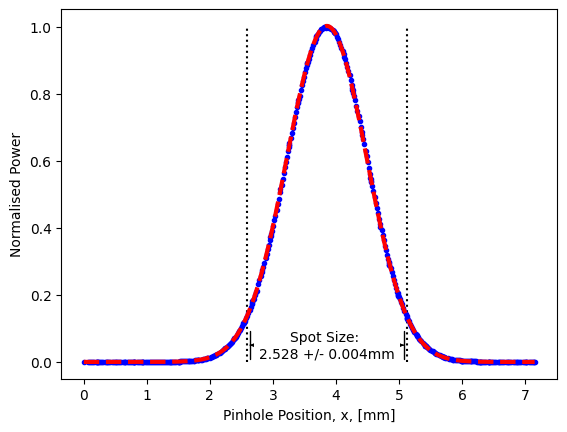

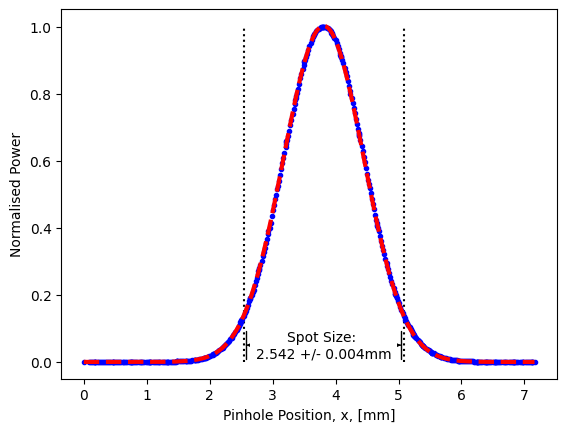

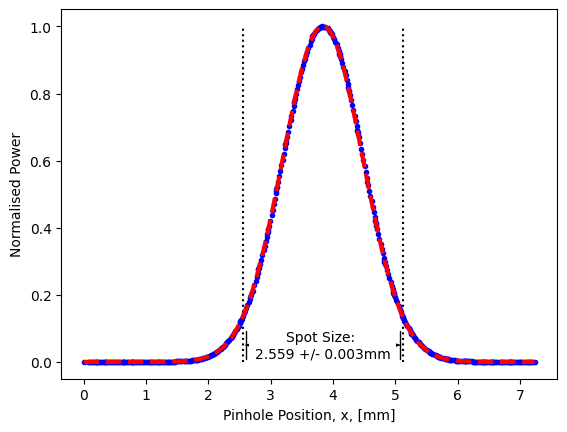

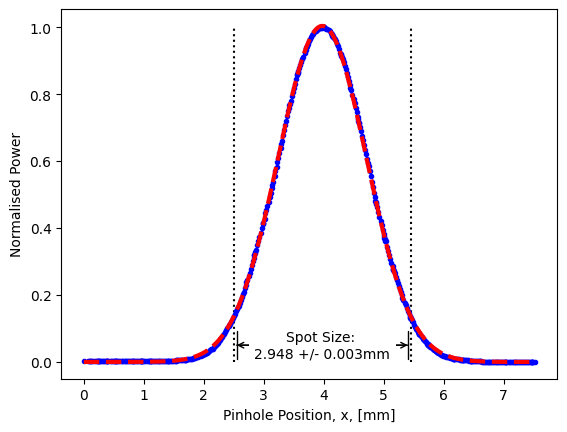

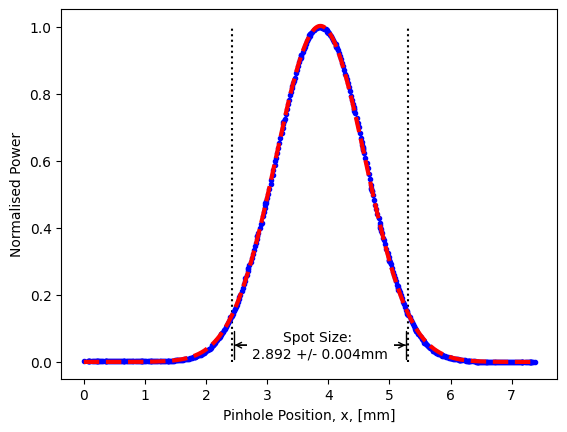

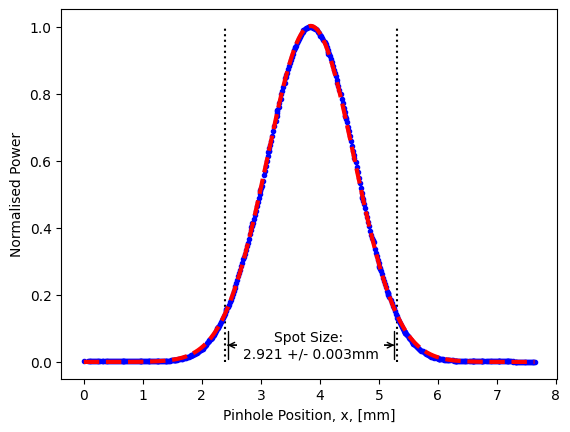

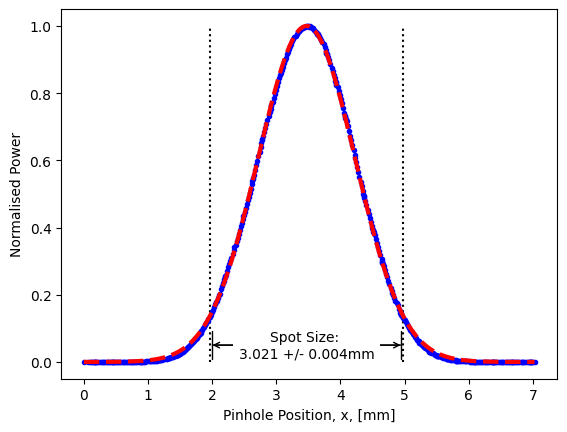

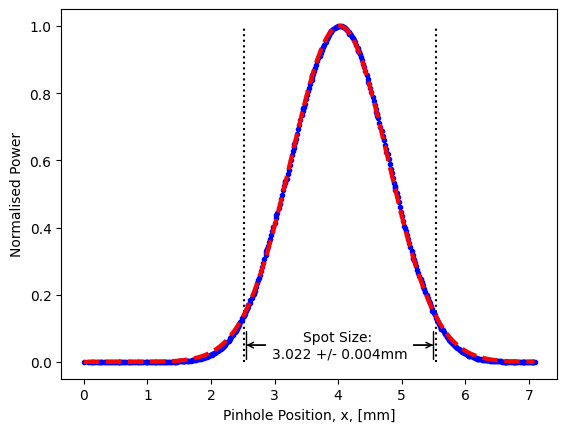

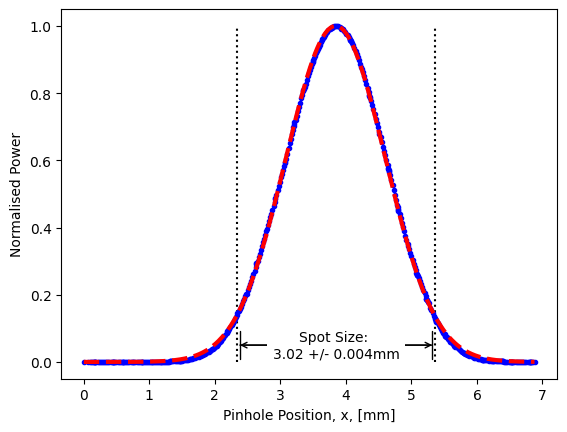

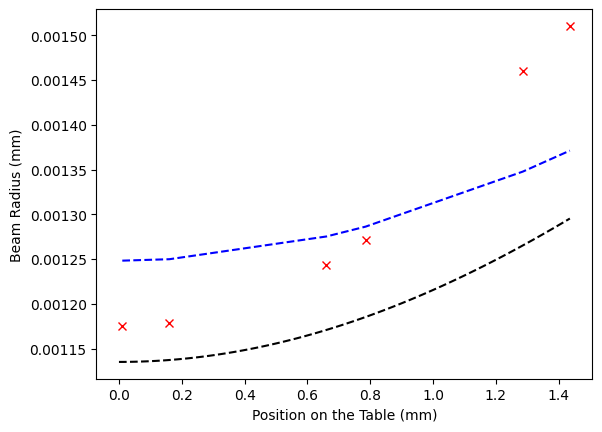

In [94]:
INITIAL_POSITION = 0.01065
ps = list(map(lambda p: (p*25*1E-3) + INITIAL_POSITION, [0, 6, 26, 31, 51, 57])) 
beam_diameters = collate_results(files, velocity_4)
ws = np.array(list(map(lambda bd: bd["value"]/2*1E-3, beam_diameters)))
av_ws = np.mean(ws.reshape(-1, 3), axis=1)
print(av_ws[0] * 2E3)

plot.plot_parametric(ps, av_ws)
plt.show()


4.37308375468999


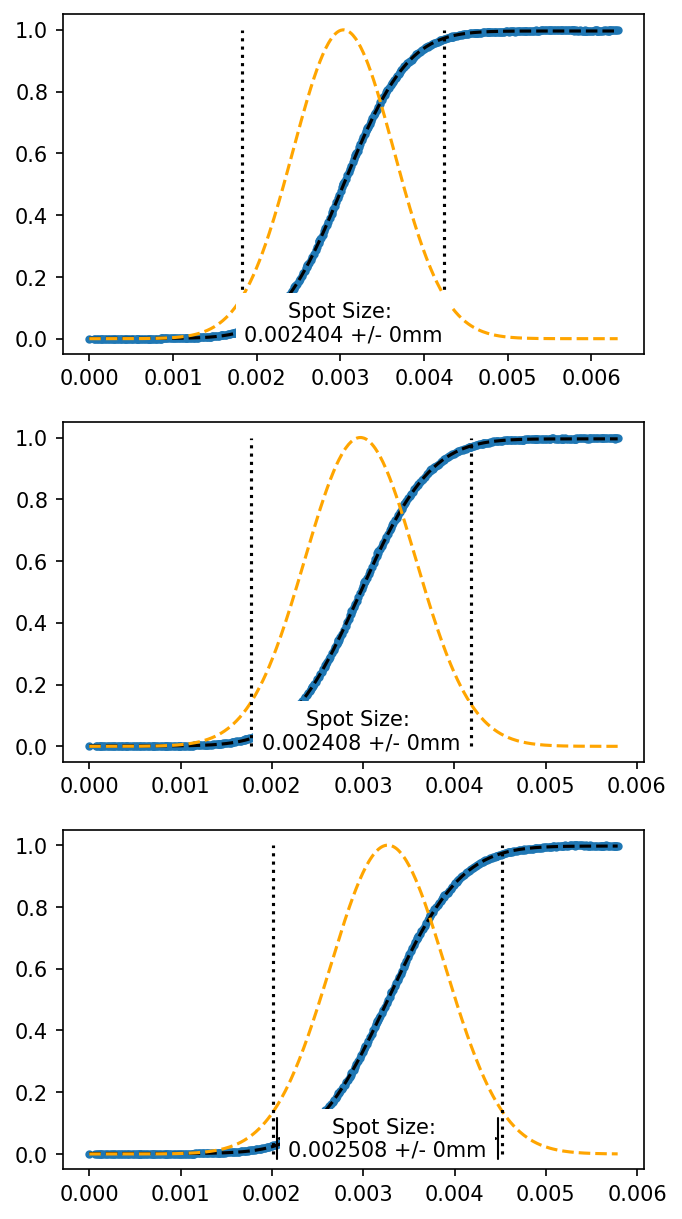

In [99]:
knife_files = np.array([f"Data/knife-edge/p0/{n}.csv" for n in range(1,4)] ).flatten()
v = velocity_4
knife_measurements = map(servo.get_data, knife_files)
displacement_data = list(map(lambda m: (m
                    .pipe(servo.reindex_timestamps_with_times)
                    .pipe(servo.calculate_displacement, v)
                    .pipe(servo.get_distances)
                    .pipe(servo.calculate_distances_error, v)
                    ), knife_measurements))

from scipy.special import erf as error_function
from scipy.optimize import curve_fit as fit
def erf(x, a, mean, root_2_std, b):
    return a*error_function((x-mean) / root_2_std) + b



f, axes = plt.subplots(3,1, figsize=(5,10), dpi=150)
ws = []
for data, ax in zip(displacement_data, axes):

    xs = data["Displacement (m)"]
    ys = analyse.normalise(data["Power (W)"])

    coeffs, _ = fit(erf, xs, ys )
    a, mu, r2std, b = coeffs
    std = r2std / np.sqrt(2) 
    

    gauss_ys = analyse.G(xs, 1, mu, std)
    
    fit_ys = erf(xs, *coeffs)
    w = coeffs[1]*(np.sqrt(2))
    ws.append(w)
    
    ax.plot(xs, ys,  linestyle='', marker='.')
    ax.plot(xs, fit_ys, linestyle='--', c='k')
    ax.plot(xs, gauss_ys, linestyle='--', c='orange')

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)
    ax.vlines(lower_bound, 0,1,linestyle="dotted", color="black")
    ax.vlines(upper_bound, 0, 1, linestyle="dotted",color="black")
    plot.draw_dimension_lines(ax, [lower_bound, upper_bound], {"value": round(upper_bound-lower_bound, 6), "err": 0})
    

diam = np.array(ws).mean()
print(diam * 1E3)
plt.show()